# DeepInference for the multivariate normal distribution
This Notebook replicates the findings for the multivariate normal scenario presented in 

_Towards end-to-end likelihood-free inference with Convolutional Neural Networks_ (Radev, Mertens, Voss)


If you have any questions, feel free to contact me:

<span style='color:blue'>ulf.mertens@psychologie.uni-heidelberg.de</span>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
from subprocess import run, check_output
import os
from decimal import Decimal
import random
import matplotlib.pyplot as plt
import time

/home/ulf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(tf.__version__)
np.random.seed(1223)

1.9.0


## Global settings

Each training example is a dataset with 200 rows and 2 columns. The `NAMES` variable will be used to display the parameter names in a nice format.

In [3]:
ROWS = 200
COLS = 2
NAMES = [r'$\mathrm{E}[\mu_1 | X]$',
         r'$\mathrm{E}[\mu_2 | X]$',
         r'$\mathrm{E}[\sigma_1 | X]$',
         r'$\mathrm{E}[\sigma_2 | X]$',
         r'$Var[\mu_1 | X]$',
         r'$Var[\mu_2 | X]$',
         r'$Var[\sigma_1 | X]$',
         r'$Var[\sigma_2 | X]$']

## Hyperparameters

The following code cell sets up the stage by creating necessary directories and setting a few hyperparameters of the model.

In [4]:
# set the path:
PATH = os.getcwd()

os.makedirs('img',exist_ok=True)
os.makedirs('model_checkpoints',exist_ok=True)

# how deep should the model be:
filters = [64,128,128]

# number of channels:
nchannels = COLS

# optimizer:
optimizer = 'adam'

# Batch size:
batchsize = 64

checkpoint_path = "model_checkpoints/trained_model.hdf5"

## Functions

Below are a few functions we need:

1. Importing data
2. Heteroscedastic loss
3. Plotting results
4. Model architecture

### Import function

In [5]:
def read_data(path,sep,rows,cols,separate_files = 1):
    """ Import train and test data."""
    
    x_sets = []
    y_sets = []
    x_names = ['xtrain' + str(i+1) + '.csv' for i in range(separate_files)]
    y_names = ['ytrain' + str(i+1) + '.csv' for i in range(separate_files)]
    
    for i in range(separate_files):
        X_train = pd.read_csv(os.path.join(path,x_names[i]),sep=sep,header=None).values
        y_train = pd.read_csv(os.path.join(path,y_names[i]),sep=sep,header=None).values
        
        x_sets.append(X_train)
        y_sets.append(y_train)
        
    X_train = np.vstack(x_sets)
    y_train = np.vstack(y_sets)
    
    X_train = X_train.reshape(X_train.shape[0],rows,cols)
    
    X_test = pd.read_csv(os.path.join(path,'xtest.csv'),sep=sep,header=None).values
    X_test = X_test.reshape(X_test.shape[0],rows,cols)
    y_test = pd.read_csv(os.path.join(path,'ytest.csv'),sep=sep,header=None).values
    return X_train, y_train, X_test, y_test

### Heteroscedastic loss function

In [6]:
def heteroscedastic_loss(true, pred):
    """ Heteroskedastic loss function."""
    params = pred.shape[1]//2
    point = pred[:, :params]
    var = pred[:, params:]
    precision = 1 / var
    return keras.backend.sum(precision * (true - point) ** 2. + keras.backend.log(var), -1)

### Plot function

In [7]:
def plot_analytic_vs_est(true, pred, names ,log=True, plot_abline=True,show=True,filename='figure.png'):
    """Create a 3x2 plot as in paper."""
    
    def abline(slope, intercept, ax):
        x = np.array(ax.get_xlim())
        y = intercept + slope * x
        return x, y 
    
    font = {'fontname':'Arial', 'fontsize': 16}
    textfont = {'fontname':'Arial', 'fontsize': 11}
    axisfont = {'fontname':'Arial', 'fontsize': 12}
    
    nmaes = [] # Normalized Mean absolute error

    f, axarr = plt.subplots(2, true.shape[1]//2, figsize=(15, 10))
    
    THREEPLACES = Decimal(10) ** -3
    
    # EXPECTATION OF BETA 1
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(true[:,i], pred[:,i],marker='o', linewidth=0,alpha=0.2,color='black')
        cor = np.corrcoef(true[:,i],pred[:,i])[0,1]
        cor_disp = str(Decimal(cor).quantize(THREEPLACES))
       
        mae = np.round(np.mean(abs((true[:,i]-pred[:,i])/true[:,i])),2)
        rmse = np.sqrt(np.mean((true[:,i]-pred[:,i])**2))
        rmse_disp = str(Decimal(rmse).quantize(THREEPLACES))
        nmaes.append(mae)
        ax.text(0.2,0.9,'RMSE: ' + rmse_disp,ha='center', va='center', transform=ax.transAxes,**textfont)
        ax.text(0.15,0.85,'r: ' + cor_disp,ha='center', va='center', transform=ax.transAxes,**textfont)
        
        if log and i >= true.shape[1]//2:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        if plot_abline:
            ax.plot(*abline(1, 0, ax),color='black')
        else:
            ax.plot(*best_line_fit(true[:,i], pred[:,i]))
        if i == 0:
            ax.set_xlabel('True',**axisfont)
            ax.set_ylabel('Estimated',**axisfont)
        ax.set_title(names[i],**font)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.set_xlim(np.min(true[:,i]),np.max(true[:,i]))
        ax.set_ylim(np.min(true[:,i]),np.max(true[:,i]))
        
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
     
    f.savefig(os.path.join(PATH,filename))
    f.subplots_adjust(hspace=.3)
    if show:
        plt.show()
    return None

### Model architecture (DeepInference)

The following function implements the _DeepInference_ model presented in the paper. 

In [8]:
def create_model(n_params, channels, filters, batchnorm = False, training = True):
    """Creates 1DConv model."""
    
    inp = keras.Input(shape=(None, channels))
    x = inp
    x = keras.layers.Conv1D(filters[0], kernel_size=1, strides=1, activation='relu')(x)
    
    for f in filters[1:]:
        x = keras.layers.Conv1D(f, kernel_size=3, strides=2, activation='relu')(x)
        #x = keras.layers.Dropout(rate=0.2)(x,training=True)
        if batchnorm:
            x = keras.layers.BatchNormalization()(x,training=training)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    mean = keras.layers.Dense(n_params)(x)
    var = keras.layers.Dense(n_params, activation='softplus')(x)
    out = keras.layers.Concatenate()([mean, var])
    model = keras.Model(inp, out)
    return model

## Import data

In [9]:
X_train, y_train, X_test, y_test = read_data('data',sep=' ',rows=ROWS,cols=COLS)

In [10]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(100000, 200, 2)
(100, 200, 2)
(100000, 4)
(100, 8)


## Training

In [11]:
keras.backend.clear_session()
deepInference = create_model(n_params=len(NAMES)//2,channels=nchannels,filters=filters)
#deepInference.summary()

In [12]:
deepInference.compile(optimizer=optimizer, loss=heteroscedastic_loss)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=False,verbose=1)

In [13]:
model_name = 'model_checkpoints/trained_model.hdf5'
if os.path.isfile(model_name):
    deepInference = keras.models.load_model(model_name,custom_objects={'heteroscedastic_loss': heteroscedastic_loss})
    
else:

    history = deepInference.fit(X_train, 
                            y_train, 
                            batch_size=batchsize,
                            epochs=10, 
                            validation_split=0.01,
                            callbacks=[earlystopper, checkpointer])

Train on 99000 samples, validate on 1000 samples
Epoch 1/10
99000/99000 [==============================] - 14s 141us/step - loss: -15.7603 - val_loss: -18.1326

Epoch 00001: val_loss improved from inf to -18.13263, saving model to model_checkpoints/trained_model.hdf5
Epoch 2/10
99000/99000 [==============================] - 12s 125us/step - loss: -18.0614 - val_loss: -18.6142

Epoch 00002: val_loss improved from -18.13263 to -18.61417, saving model to model_checkpoints/trained_model.hdf5
Epoch 3/10
99000/99000 [==============================] - 12s 126us/step - loss: -18.3995 - val_loss: -18.5684

Epoch 00003: val_loss did not improve from -18.61417
Epoch 4/10
99000/99000 [==============================] - 12s 126us/step - loss: -18.5605 - val_loss: -18.8912

Epoch 00004: val_loss improved from -18.61417 to -18.89122, saving model to model_checkpoints/trained_model.hdf5
Epoch 5/10
99000/99000 [==============================] - 12s 126us/step - loss: -18.6542 - val_loss: -19.0388

Epoch

In [14]:
preds = deepInference.predict(X_test)

## Plot Results

/home/ulf/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


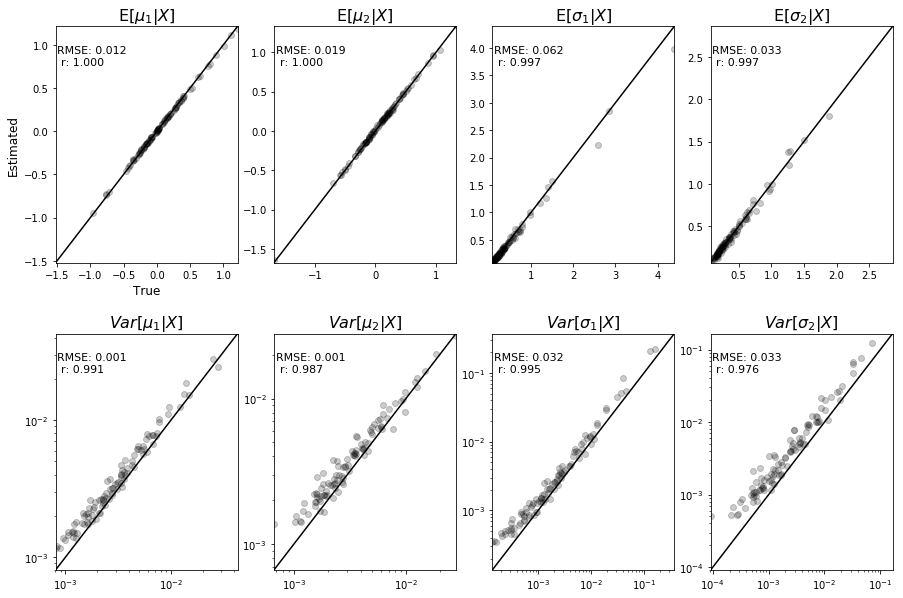

In [15]:
plot_analytic_vs_est(y_test, preds,NAMES,log=True,show=True,filename='img/results.png')